# 15.077: Problem Set 8
Alex Berke (aberke)

##  Reading
Hastie, T., Tibshirani, R., and Friedman, J., The Elements of Statistical Learning: Data Mining, Inference and Prediction, Springer, 2nd ed., 2009 (ISBN 978-0-387-84857-0). https://web.stanford.edu/~hastie/ElemStatLearn/

H 8.7 - 8.9, 10.1-10.14, 11.9, 15.1-15.3, 16.1 - 16.2.2, Rice 3.5.2 (pages 94,95), 8.6


In [71]:
%config Completer.use_jedi = False # autocomplete

import numpy as np
import pandas as pd

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Problems

### 1. Competitive Auctions on eBay.com.

#### The file eBayAuctions.xls contains information on 1972 auctions transacted on eBay.com.  The goal is to use these data to build a model that will classify competitive auctions from noncompetitive ones. A competitive auction is defined as an  auction with at least two bids placed on the item auctioned.  The data include variables that describe the item (auction category), the seller (his/her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day-of-week of auction close).  In addition, we have the price at which the auction closed.  The goal is to predict whether or not the auction will be competitive.


In [47]:
auctions = pd.read_excel('eBayAuctions.xls')
auctions.head(3)

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


#### Data Preprocessing.  
Create dummy variables for the categorical predictors.  These include Category (18 categories), Currency (USD, GBP, Euro), EndDay (Monday-Sunday), and Duration (1, 3, 5, 7, or 10 days).  Split the data into training and validation datasets using a 60% : 40% ratio.

#### Set up
As we can see below, there are many categories where the total values are < 50, making it impossible to consider that feature for splitting in the tree, since we require at least 50 samples in any leaf node.

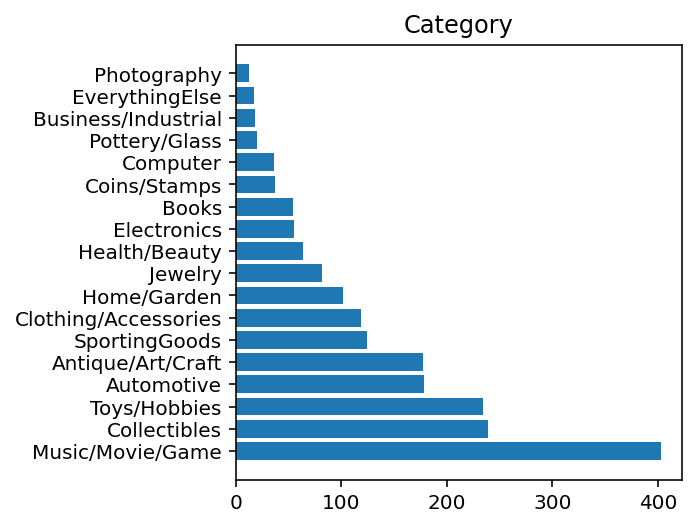

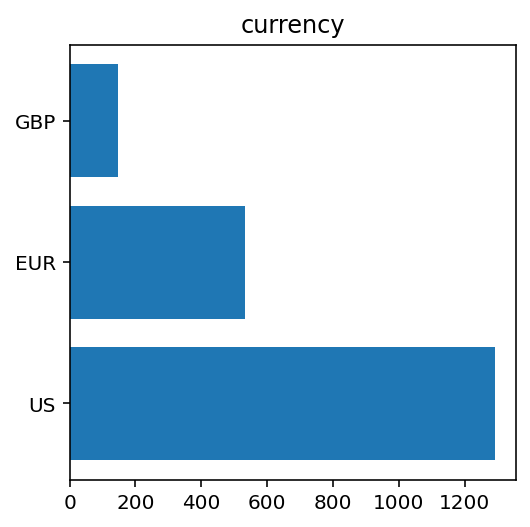

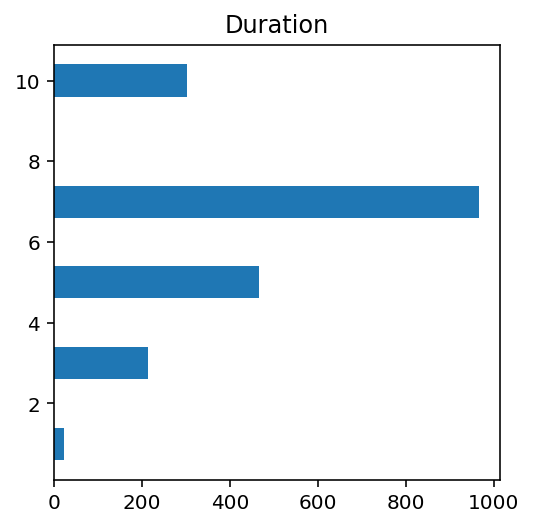

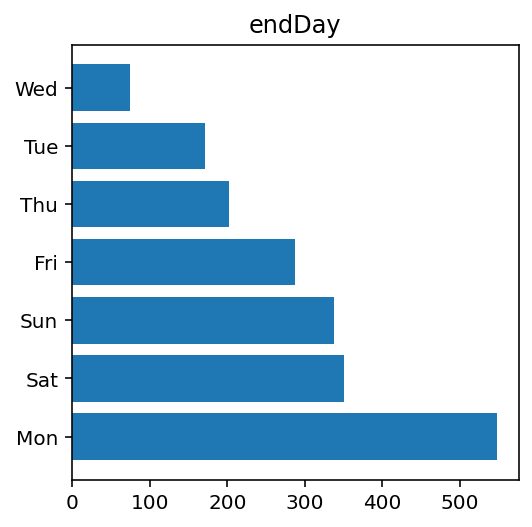

In [51]:
for c in ['Category', 'currency','Duration','endDay']:
    fig,ax = plt.subplots(1, figsize=(4,4))
    ax.barh(auctions[c].value_counts().index, auctions[c].value_counts())
    ax.set_title(c)

We combine categorical variables as follows.

'Category' variables with N < 100 become 'EverythingElse'.

'Duration' is collapsed to 3 levels: < 5 days, 5 days, > 5 days

In [52]:
category_counts = auctions['Category'].value_counts()
small_categories = category_counts[category_counts < 100]
small_categories

Jewelry                82
Health/Beauty          64
Electronics            55
Books                  54
Coins/Stamps           37
Computer               36
Pottery/Glass          20
Business/Industrial    18
EverythingElse         17
Photography            13
Name: Category, dtype: int64

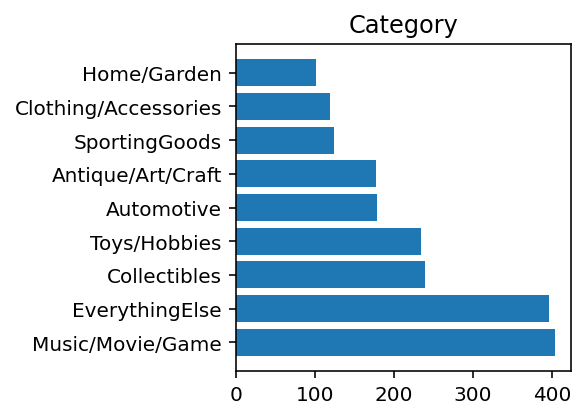

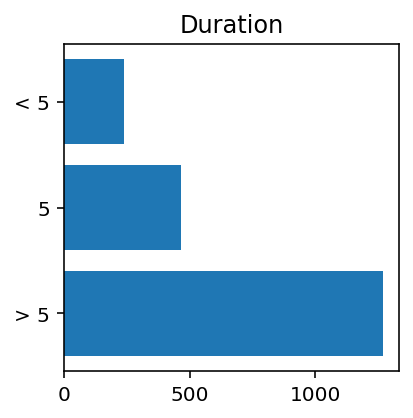

In [59]:
X = auctions[auctions.columns[:-1]].drop('ClosePrice', axis=1) # ClosePrice not used
X['Category'] = X['Category'].map(lambda c: 'EverythingElse' if c in small_categories else c)
def duration3(d):
    if d < 5:
        return '< 5'
    elif d  > 5:
        return '> 5'
    return '5'
X['Duration'] = X['Duration'].map(duration3)

for c in ['Category', 'Duration']:
    fig,ax = plt.subplots(1, figsize=(3,3))
    ax.barh(X[c].value_counts().index, X[c].value_counts())
    ax.set_title(c)

In [60]:
X = pd.get_dummies(data=X, columns=['Category','currency','endDay','Duration'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print('X, y split into training and validatioin sets using a 60:40 ratio')
print('N train = %s' % len(X_train))
print('N validate = %s' % len(X_test))
X_train.head()

X, y split into training and validatioin sets using a 60:40 ratio
N train = 1183
N validate = 789


,sellerRating,OpenPrice,Category_Antique/Art/Craft,Category_Automotive,Category_Clothing/Accessories,Category_Collectibles,Category_EverythingElse,Category_Home/Garden,Category_Music/Movie/Game,Category_SportingGoods,...,endDay_Fri,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed,Duration_5,Duration_< 5,Duration_> 5
1484,9003,7.490000,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1159,4,1.229697,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
430,1545,2.443720,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1772,572,30.000000,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
195,158,1.230000,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


#### Decision tree from part (a) 

In [73]:
RANDOM_STATE = 0 # features are permuted at each  fit. Defining  random state makes classifier deterministic
a_clf = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    min_samples_leaf=50,
    max_depth=6,
).fit(X_train, y_train)

#### h.  Run a boosted tree with the same predictors as in part (a).  For the validation set, what is the overall accuracy?

We use the default parameters with n=100 estimators, learning rate=0.1.

In [80]:
clf = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    min_samples_leaf=50,
    max_depth=6,
).fit(X_train, y_train)
print('accuracy score for boosted tree: %0.3f' % clf.score(X_test, y_test))

accuracy score for boosted tree: 0.758


#### i.  Run a bagged tree with the same predictors as in part (a).  For the validation set, what is the overall accuracy?

In [78]:
clf = BaggingClassifier(a_clf,
    random_state=RANDOM_STATE,
).fit(X_train, y_train)
print('accuracy score for bagged tree: %0.3f' % clf.score(X_test, y_test))

accuracy score for bagged tree: 0.719


#### j. Run a random forest with the same predictors as in part (a).  For the validation set, what is the overall accuracy?

In [85]:
clf = RandomForestClassifier(
    random_state=RANDOM_STATE,
).fit(X_train, y_train)
print('accuracy score for random forest: %0.3f' % clf.score(X_test, y_test))

accuracy score for random forest: 0.731


#### k.  Compare the accuracy of the trees in f, h, i, and j. (f is from HW#6)

The tree from (f) is rebuilt below to retrieve the accuracy score.

In [86]:
clf = DecisionTreeClassifier(
    random_state=0, # features are permuted at each  fit. Defining  random state makes classifier deterministic
    min_samples_leaf=50,
    max_depth=4, # 5  levels
).fit(X_train, y_train)
print('f. tree score: %0.3f'% clf.score(X_test, y_test))

f. tree score: 0.715


#### Comparisons
- f. accuracy score: 0.715. (Decision tree classifier with 5 levels.)
- boosted tree accuracy score: 0.758
- bagged tree accuracy score: 0.719
- random forest accuracy score: 0.731

As expected, the boosted tree performs better than the bagged tree. 
The boosted tree has the best performance. With more parameter tuning, it is likely that the random forest accuracy could improve as well.

All of these perform better than the vanilla tree from (f).

### 2. H15.6 (Spam data again) 
### Fit a series of random-forest classifiers to the spam data, to explore the sensitivity to the parameter m. Plot both the oob error as well as the test error against a suitably chosen range of values for m. 


I divide the spam data into a 80/20 training vs test set.

The OOB error comes from the training set. The test error comes from the test set (obv.).

What is a suitable range for m? For classification, the default value of m is ⌊√p⌋.

For the spam data, p=57, ⌊√p⌋=7. For the range of m, we will try ⌊(0.5)√p⌋ to ⌊(0.5)p⌋.


While m is one parameter, another important parameter is the number of trees/classifiers within the random forest.

Section 15.2 of [H] suggests that results will stabilize at about 200 trees. We use 200 trees as a constant parameter below.

For reference on what kinds of results we may expect, from section 15.2, page 590 of [H]: "A random forest classifier achieves 4.88% misclassification error on the spam test data, which compares well with all other methods".

In [24]:
spam = pd.read_csv('spam.txt', header=None, delimiter=" ")
X, y = spam[list(range(57))], spam[57]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
# spam

data partitioned into  80-20 train-test split
train size = 3680; test size = 921


In [25]:
p = len(X.columns)
print('p = %s; ⌊√p⌋ = %s' % (p, int(np.sqrt(p))))
m_range = (int(0.5 * np.sqrt(p)), int(0.5*p))
print('range of m: %s - %s' % m_range)

p = 57; ⌊√p⌋ = 7
range of m: 3 - 28


In [42]:
oob_errors = []
test_errors = []
m_values = list(range(m_range[0], m_range[1]+1))

for i, m in enumerate(m_values):
    if i%10 == 0:
        print('%s/%s: m = %s' % (i, len(m_values), m))
    clf = RandomForestClassifier(
        n_estimators=200,
        oob_score=True,
        max_features=m, 
        random_state=0
    )
    clf.fit(X_train, y_train)
    oob_error = 1 - clf.oob_score_
    oob_errors += [oob_error]
    test_error = 1 - clf.score(X_test, y_test)
    test_errors += [test_error]

0/26: m = 3
10/26: m = 13
20/26: m = 23


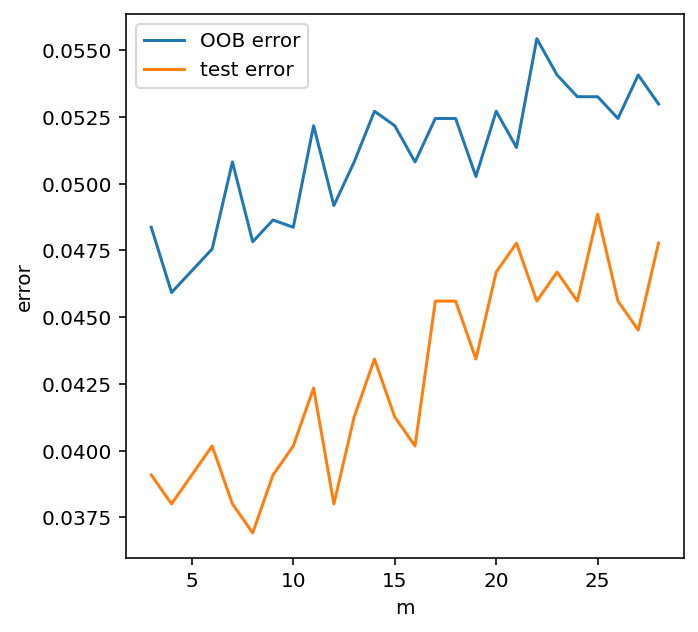

In [44]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(m_values, oob_errors, label='OOB error')
ax.plot(m_values, test_errors, label='test error')
ax.set_xlabel('m')
ax.set_ylabel('error')
_ = ax.legend()

The test errors seem quite unstable. Overall, the OOB errors and test errors display similar trends.

The recommended value of m = ⌊√p⌋ = 7 does seem like a good value for reducing test error.